In [27]:
import os
import wandb
import pandas as pd
import seaborn as sns
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from PIL import Image
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    precision_recall_curve
)

plt.style.use('seaborn')
%matplotlib inline

### Split train and test

In [2]:
TRAIN_SIZE = 0.9

for img_class in os.listdir('./raw_dataset'):
    images = os.listdir(f'./raw_dataset/{img_class}')
    np.random.shuffle(images)
    
    total = len(images)
    if total == 0:
        continue

    train = np.floor(total * TRAIN_SIZE)
    test = total - train
    
    assert train + test == total
    
    print('Class:', img_class)
    print("Total:", total)
    print("Train:", train)
    print("Test:", test)
    print('-' * 50)
    
    os.makedirs(f'./dataset/train/{img_class}', exist_ok=True)
    os.makedirs(f'./dataset/test/{img_class}', exist_ok=True)
    
    for s_no, img in enumerate(images):
        source = f"./raw_dataset/{img_class}/{img}"
        if s_no < train:
            destination = f"./dataset/train/{img_class}/{img}"
        else:
            destination = f"./dataset/test/{img_class}/{img}"
            
        os.rename(source, destination)

    train_images = len(os.listdir(f"./dataset/train/{img_class}"))
    test_images = len(os.listdir(f"./dataset/test/{img_class}"))
    
    assert train_images == train
    assert test_images == test
    assert train_images + test_images == total

FileNotFoundError: [Errno 2] No such file or directory: './raw_dataset'

### Hyperparameters

In [3]:
config = {
    'seed': 42,
    'img_size': 256,
    'color_mode': 'rgb',
    'batch_size': 64,
    'epochs': 10,
    'lr': 1e-3,
}

### Dataset

In [23]:
print("\nTraining Dataset")
train_ds = tf.keras.utils.image_dataset_from_directory(
    directory='dataset/train',
    validation_split=0.2,
    subset='training',
    label_mode='int',
    color_mode=config['color_mode'],
    seed=config['seed'],
    image_size=(config['img_size'], config['img_size']),
    batch_size=config['batch_size'],
)

print("\nValidation Dataset")
val_ds = tf.keras.utils.image_dataset_from_directory(
    directory='dataset/train',
    validation_split=0.2,
    subset='validation',
    label_mode='int',
    color_mode=config['color_mode'],
    seed=config['seed'],
    image_size=(config['img_size'], config['img_size']),
    batch_size=config['batch_size'],
    shuffle=False
)

print("\nTesting Dataset")
test_ds = tf.keras.utils.image_dataset_from_directory(
    directory='dataset/test',
    label_mode='int',
    color_mode=config['color_mode'],
    seed=config['seed'],
    image_size=(config['img_size'], config['img_size']),
    batch_size=config['batch_size'],
    shuffle=False
)


Training Dataset
Found 18568 files belonging to 15 classes.
Using 14855 files for training.

Validation Dataset
Found 18568 files belonging to 15 classes.
Using 3713 files for validation.

Testing Dataset
Found 2070 files belonging to 15 classes.


In [24]:
labels = train_ds.class_names
n_classes = len(labels)
print("Number of classes:", n_classes)
labels

Number of classes: 15


['pepper_bell_bacterial_spot',
 'pepper_bell_healthy',
 'potato_early_blight',
 'potato_healthy',
 'potato_late_blight',
 'tomato_bacterial_spot',
 'tomato_early_blight',
 'tomato_healthy',
 'tomato_late_blight',
 'tomato_leaf_mold',
 'tomato_mosaic_virus',
 'tomato_septoria_leaf_spot',
 'tomato_target_spot',
 'tomato_two_spotted_spider_mite',
 'tomato_yellowleaf_curl_virus']

In [7]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

### Data Augmentation

2022-06-09 18:18:10.628001: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


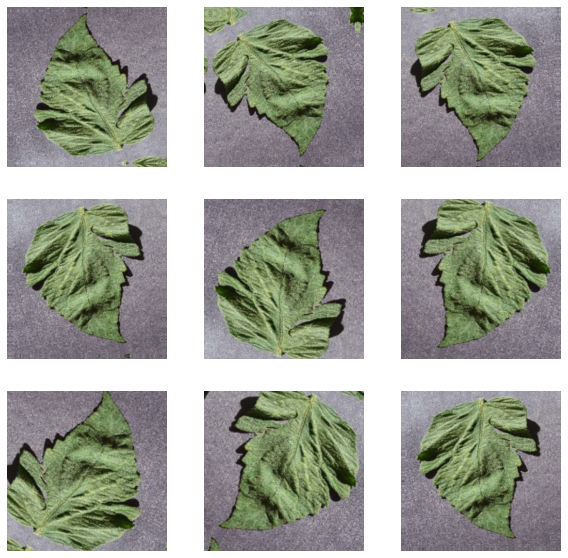

In [8]:
def get_data_aug():
    if config['color_mode'] == 'rgb':
        input_shape = (config['img_size'], config['img_size'], 3)
    else:
        input_shape = (config['img_size'], config['img_size'], 1)

    with tf.device('cpu:0'):
        model = tf.keras.Sequential(name='data_augmentation')

        model.add(tf.keras.layers.RandomFlip('horizontal_and_vertical', seed=config['seed'], input_shape=input_shape))
        model.add(tf.keras.layers.RandomRotation(factor=0.1, seed=config['seed']))
        model.add(tf.keras.layers.RandomZoom(height_factor=0.1, seed=config['seed']))
    
    return model


data_augmentation = get_data_aug()
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        aug_img = data_augmentation(images)

        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(aug_img[0].numpy().astype('uint8'))
        plt.axis('off')

In [9]:
def get_resize_and_rescale(input_shape):
    model = tf.keras.Sequential(name='resize_and_rescale')
    
    model.add(tf.keras.layers.Resizing(config['img_size'], config['img_size'], input_shape=input_shape))
    model.add(tf.keras.layers.Rescaling(1./255))

    return model

In [10]:
if config['color_mode'] == 'rgb':
    input_shape = (config['img_size'], config['img_size'], 3)
else:
    input_shape = (config['img_size'], config['img_size'], 1)

resize_and_rescale = get_resize_and_rescale(input_shape)
    
model = tf.keras.Sequential()

model.add(resize_and_rescale)

model.add(tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))

model.add(tf.keras.layers.Dense(n_classes, activation='linear'))

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(learning_rate=config['lr']),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resize_and_rescale (Sequent  (None, 256, 256, 3)      0         
 ial)                                                            
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                        

In [11]:
wandb.init(config=config, project='Plant-Disease', name='baseline')

wandb: Currently logged in as: gautamj. Use `wandb login --relogin` to force relogin


In [12]:
mc = tf.keras.callbacks.ModelCheckpoint(
    filepath='models/weights-{epoch:03d}-{val_loss:.4f}.hdf5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
)

wb = wandb.keras.WandbCallback()

callbacks = [mc, wb]

history = model.fit(train_ds, validation_data=val_ds, epochs=config['epochs'],
                    callbacks=callbacks, verbose=1)

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/10


2022-06-09 18:20:22.728990: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


233/233 [==============================] - ETA: 0s - loss: 2.0715 - accuracy: 0.3180

2022-06-09 18:22:38.148585: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


233/233 [==============================] - 147s 620ms/step - loss: 2.0715 - accuracy: 0.3180 - val_loss: 0.6862 - val_accuracy: 0.7840 - _timestamp: 1654779168.0000 - _runtime: 241.0000
Epoch 2/10
233/233 [==============================] - 163s 699ms/step - loss: 1.0142 - accuracy: 0.6618 - val_loss: 0.3467 - val_accuracy: 0.8880 - _timestamp: 1654779332.0000 - _runtime: 405.0000
Epoch 3/10
233/233 [==============================] - 178s 765ms/step - loss: 0.5888 - accuracy: 0.8038 - val_loss: 0.1121 - val_accuracy: 0.9731 - _timestamp: 1654779510.0000 - _runtime: 583.0000
Epoch 4/10
233/233 [==============================] - 215s 921ms/step - loss: 0.3661 - accuracy: 0.8773 - val_loss: 0.0742 - val_accuracy: 0.9785 - _timestamp: 1654779724.0000 - _runtime: 797.0000
Epoch 5/10
233/233 [==============================] - 187s 801ms/step - loss: 0.2917 - accuracy: 0.9010 - val_loss: 0.1730 - val_accuracy: 0.9391 - _timestamp: 1654779911.0000 - _runtime: 984.0000
Epoch 6/10
233/233 [======

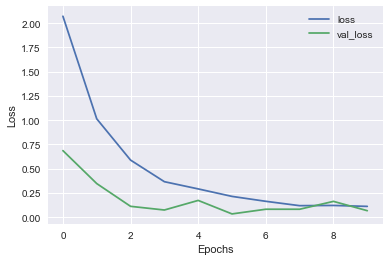

/Users/gautam/miniforge3/lib/python3.9/site-packages/plotly/matplotlylib/renderer.py:611: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



In [13]:
fig, ax = plt.subplots()
loss = history.history['loss']
val_loss = history.history['val_loss']
ax.plot(loss, label='loss')
ax.plot(val_loss, label='val_loss')
ax.legend()
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
plt.show()

wandb.log({'Loss Chart': fig})

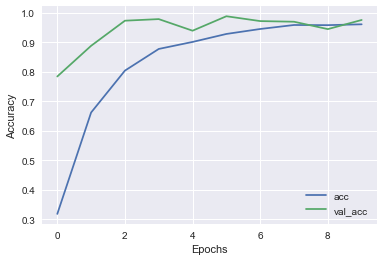

In [15]:
fig, ax = plt.subplots()
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
ax.plot(acc, label='acc')
ax.plot(val_acc, label='val_acc')
ax.legend()
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
plt.show()

wandb.log({'Acc Chart': fig})

In [16]:
model = tf.keras.models.load_model('models/baseline_best_0.0339.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resize_and_rescale (Sequent  (None, 256, 256, 3)      0         
 ial)                                                            
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                        

In [17]:
test_loss, test_acc = model.evaluate(test_ds)
wandb.log({'test_loss': test_loss})
wandb.log({'test_acc': test_acc})

2022-06-09 19:18:08.325008: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


33/33 [==============================] - 7s 154ms/step - loss: 0.2944 - accuracy: 0.9082
